CLIP as binary image classification:

In [15]:
#Import packages
import os
import clip
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import json
import cv2
from torchvision.transforms import ToTensor
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix

In [17]:
# Define device
if torch.cuda.is_available():
    device = torch.device("cuda") # use CUDA device
#elif torch.backends.mps.is_available():
#    device = torch.device("mps") # use MacOS GPU device (e.g., for M2 chips)
else:
    device = torch.device("cpu") # use CPU device
device

device(type='cpu')

In [18]:
#Load CLIP model - ViT B32
model, preprocess = clip.load('ViT-B/16', device, jit=False)

In [19]:
# Load the dataset
class ImageTitleDataset(Dataset):
    def __init__(self, list_video_path, list_labels, class_names, transform_image):
        #to handle the parent class
        super().__init__()
        #Initalize image paths and corresponding texts
        self.video_path = list_video_path
        #Initialize labels (0 or 1)
        self.labels = list_labels
        #Initialize class names (no smoke or smoke)
        self.class_names = class_names
        #Transform to tensor
        #self.transforms = ToTensor()
        self.transform_image = transform_image

    @staticmethod
    #Function to create a square-shaped image from the video (similar to 1 long image)
    #To do: what if the video has more frames than 36?
    def preprocess_video_to_image_grid_version(video_path, num_rows=6, num_cols=6):
        #Open the video file
        video = cv2.VideoCapture(video_path)
        #Create list for extracted frames
        frames = []
        #Handle if video can't be opened
        if not video.isOpened():
            print("Error: Could not open video file")
        else:
            while True:
                is_read, frame = video.read()
                if not is_read:
                    break
                frames.append(frame)
            video.release()
        
        if len(frames) != 36:
            print("Num of frames are not 36")
            print("Num of frames for video on ", video_path, "is ", len(frames))
        
        # Create  and store rows in the grids
        rows_list = []
        for i in range(num_rows):
            #create rows from the frames using indexes -- for example, if i=0, then between the 0th and 6th frame
            row = np.concatenate(frames[i * num_cols: (i + 1) * num_cols], axis=1)
            rows_list.append(row)
        
        # Concatenate grid vertically to create a single square-shaped image from the smoke video
        concatenated_frames = np.concatenate(rows_list, axis=0)
        return concatenated_frames

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #tranform videos into images and preprocess with clip's function
        video_path = self.video_path[idx]
        image = self.preprocess_video_to_image_grid_version(video_path)
        image = Image.fromarray(image)
        image = self.transform_image(image)
        #image = preprocess(image)
        #get the corresponding class names and tokenize
        true_label = self.labels[idx]
        label = self.class_names[true_label]
        label = clip.tokenize(label, context_length=77, truncate=True)
        return image, label, true_label

In [20]:
#Define training data
# Load the JSON metadata
with open('data/datasets/experimental_ijmond_dataset.json', 'r') as f:
    train_data = json.load(f)
# Convert the dataset to a Pandas DataFrame
train_data = pd.DataFrame(train_data)
# Prepare the list of video file paths and labels
list_video_path = [os.path.join("data/ijmond_videos/", f"{fn}.mp4") for fn in train_data['file_name']]
#list_labels = dataset['label'].tolist()
list_labels = [int(label) for label in train_data['label']]
#Define class names in a list - it needs prompt engineering
class_names = ["a photo of factories with clear sky above chimney", "a photo of factories emiting smoke from chimney"]

In [21]:
# Define input resolution
input_resolution = (224, 224)

# Define the transformation pipeline - from CLIP preprocessor without random crop augmentation
transform = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711])
])

In [22]:
# Create dataset and data loader for training
dataset = ImageTitleDataset(list_video_path, list_labels, class_names, transform)
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [23]:
# Create dataset and data loader for training
dataset = ImageTitleDataset(list_video_path[20:], list_labels[20:], class_names, transform)
val_data = DataLoader(dataset, batch_size=4, shuffle=False)

In [24]:
#Define validation data
# Load the JSON metadata
with open('data/datasets/experimental_ijmond_dataset.json', 'r') as f:
    val_data = json.load(f)
# Convert the dataset to a Pandas DataFrame
val_data = pd.DataFrame(val_data)
# Prepare the list of video file paths and labels
list_val_video_path = [os.path.join("data/ijmond_videos/", f"{fn}.mp4") for fn in val_data['file_name']]
#list_labels = dataset['label'].tolist()
list_val_labels = [int(label) for label in val_data['label']]

In [25]:
# Function to convert model's parameters to FP32 format
#This is done so that our model loads in the provided memory
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

# Check if the device is set to CPU
if device == "cpu":
  model.float()

# Prepare the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)

#The lr, betas, eps and weight decay are from the CLIP paper

# Specify the loss functions - for images and for texts
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

In [28]:
# Model training
num_epochs = 5
for epoch in range(num_epochs):
  model.train()
  pbar = tqdm(train_dataloader, total=len(train_dataloader))
  for batch in pbar:
      # Extract images and texts from the batch
      images, labels, true_label = batch 

      # Move images and texts to the specified device (CPU or GPU)
      images= images.to(device)
      texts = labels.to(device)
      true_label = true_label.to(device)
      text_inputs = clip.tokenize(class_names).to(device)

      #Squeeze texts tensor to match the required size
      texts = texts.squeeze(dim = 1)
      text_inputs.squeeze(dim = 1)

      # Forward pass - Run the model on the input data (images and texts)
      #logits_per_image, logits_per_text = model(images, texts)
      logits_per_image, logits_per_text = model(images, text_inputs)

      #Get ground truth - here the true label
      ground_truth = torch.tensor(true_label, dtype=torch.long, device=device)

      #Transform logits to float to match required dtype 
      logits_per_image = logits_per_image.float()
      logits_per_text = logits_per_text.float()

      #Inspect logits
      print('Logits_per_text shape after forward passing: ', logits_per_text.shape)
      print('Logits_per_image shape after forward passing: ', logits_per_image.shape)
      print('Logits_per_text after forward passing: ', logits_per_text.T)
      print('Logits_per_image after forward passing: ', logits_per_image)

      #Compute loss - contrastive loss to pull similar pairs closer together
      total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text.T,ground_truth))/2

      #One image should match 1 label, but 1 label can match will multiple images (when single label classification)
      #total_loss = loss_img(logits_per_image,ground_truth) 
      
      # Zero out gradients for the optimizer (Adam) - to prevent adding gradients to previous ones
      optimizer.zero_grad()

      # Backward pass
      total_loss.backward()
      if device == "cpu":
         optimizer.step()
      else : 
        # Convert model's parameters to FP32 format, update, and convert back
        convert_models_to_fp32(model)
        optimizer.step()
        clip.model.convert_weights(model)
      # Update the progress bar with the current epoch and loss
      pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

  model.eval()
  val_losses = []
  val_accs = []
  all_preds = []
  all_labels = []
  with torch.no_grad():
      for batch in tqdm(val_data, total=len(val_data)):
            # Extract images and texts from the batch
            images, labels, true_label = batch 
            # Move images and texts to the specified device
            images = images.to(device)
            texts = labels.to(device)
            true_label = true_label.to(device)
            text_inputs = clip.tokenize(class_names).to(device)
            texts = texts.squeeze(dim=1)
            text_inputs.squeeze(dim=1)

            # Forward pass
            logits_per_image, logits_per_text = model(images, text_inputs)

            # Compute loss
            ground_truth = torch.tensor(true_label, dtype=torch.long, device=device)
            logits_per_image = logits_per_image.float()
            logits_per_text = logits_per_text.float()
            total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text.T, ground_truth)) / 2

            # Compute predicted labels
            pred_labels = logits_per_image.argmax(dim=1)

            print('Ground truth: ', ground_truth)
            print('Perdicted label: ', pred_labels)

            # Append predicted labels and ground truth labels
            all_preds.extend(pred_labels.cpu().numpy())
            all_labels.extend(ground_truth.cpu().numpy())

            # Append loss
            val_losses.append(total_loss.item())
  
  # Calculate confusion matrix
  conf_matrix = confusion_matrix(all_labels, all_preds)

  # Print or visualize the confusion matrix
  print("Confusion Matrix:")
  print(conf_matrix)
  

  0%|          | 0/7 [00:00<?, ?it/s]/var/folders/9v/r3fdnxqn6v740_k7q9q14pym0000gn/T/ipykernel_99459/3105613334.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth = torch.tensor(true_label, dtype=torch.long, device=device)


Logits_per_text shape after forward passing:  torch.Size([2, 4])
Logits_per_image shape after forward passing:  torch.Size([4, 2])
Logits_per_text after forward passing:  tensor([[21.1719, 20.7656],
        [21.1562, 20.7500],
        [21.1094, 20.7031],
        [21.1094, 20.7031]], grad_fn=<PermuteBackward0>)
Logits_per_image after forward passing:  tensor([[21.1719, 20.7656],
        [21.1562, 20.7500],
        [21.1094, 20.7031],
        [21.1094, 20.7031]], grad_fn=<ToCopyBackward0>)


Epoch 0/5, Loss: 0.6121:  14%|█▍        | 1/7 [04:41<28:09, 281.62s/it]

Logits_per_text shape after forward passing:  torch.Size([2, 4])
Logits_per_image shape after forward passing:  torch.Size([4, 2])
Logits_per_text after forward passing:  tensor([[21.2812, 20.6875],
        [21.2812, 20.6875],
        [21.2969, 20.7031],
        [21.2969, 20.7031]], grad_fn=<PermuteBackward0>)
Logits_per_image after forward passing:  tensor([[21.2812, 20.6875],
        [21.2812, 20.6875],
        [21.2969, 20.7031],
        [21.2969, 20.7031]], grad_fn=<ToCopyBackward0>)


Epoch 0/5, Loss: 0.7366:  29%|██▊       | 2/7 [09:31<23:51, 286.33s/it]

Logits_per_text shape after forward passing:  torch.Size([2, 4])
Logits_per_image shape after forward passing:  torch.Size([4, 2])
Logits_per_text after forward passing:  tensor([[21.3281, 20.9219],
        [21.5312, 21.1250],
        [21.5781, 21.1719],
        [21.5781, 21.1719]], grad_fn=<PermuteBackward0>)
Logits_per_image after forward passing:  tensor([[21.3281, 20.9219],
        [21.5312, 21.1250],
        [21.5781, 21.1719],
        [21.5781, 21.1719]], grad_fn=<ToCopyBackward0>)


Epoch 0/5, Loss: 0.7136:  43%|████▎     | 3/7 [14:28<19:24, 291.14s/it]

Logits_per_text shape after forward passing:  torch.Size([2, 4])
Logits_per_image shape after forward passing:  torch.Size([4, 2])
Logits_per_text after forward passing:  tensor([[21.8438, 21.6406],
        [21.7188, 21.5000],
        [21.8906, 21.6719],
        [21.9062, 21.7031]], grad_fn=<PermuteBackward0>)
Logits_per_image after forward passing:  tensor([[21.8438, 21.6406],
        [21.7188, 21.5000],
        [21.8906, 21.6719],
        [21.9062, 21.7031]], grad_fn=<ToCopyBackward0>)


Epoch 0/5, Loss: 0.7495:  57%|█████▋    | 4/7 [19:14<14:28, 289.44s/it]

Logits_per_text shape after forward passing:  torch.Size([2, 4])
Logits_per_image shape after forward passing:  torch.Size([4, 2])
Logits_per_text after forward passing:  tensor([[22.7031, 22.6562],
        [22.6406, 22.5938],
        [22.7031, 22.6562],
        [22.6875, 22.6406]], grad_fn=<PermuteBackward0>)
Logits_per_image after forward passing:  tensor([[22.7031, 22.6562],
        [22.6406, 22.5938],
        [22.7031, 22.6562],
        [22.6875, 22.6406]], grad_fn=<ToCopyBackward0>)


Epoch 0/5, Loss: 0.6934:  71%|███████▏  | 5/7 [23:42<09:23, 281.72s/it]

Logits_per_text shape after forward passing:  torch.Size([2, 4])
Logits_per_image shape after forward passing:  torch.Size([4, 2])
Logits_per_text after forward passing:  tensor([[23.3281, 23.3438],
        [23.2969, 23.3125],
        [23.1875, 23.2188],
        [23.2188, 23.2344]], grad_fn=<PermuteBackward0>)
Logits_per_image after forward passing:  tensor([[23.3281, 23.3438],
        [23.2969, 23.3125],
        [23.1875, 23.2188],
        [23.2188, 23.2344]], grad_fn=<ToCopyBackward0>)


Epoch 0/5, Loss: 0.6873:  86%|████████▌ | 6/7 [28:11<04:37, 277.24s/it]

Logits_per_text shape after forward passing:  torch.Size([2, 2])
Logits_per_image shape after forward passing:  torch.Size([2, 2])
Logits_per_text after forward passing:  tensor([[23.8281, 24.2344],
        [23.7969, 24.2188]], grad_fn=<PermuteBackward0>)
Logits_per_image after forward passing:  tensor([[23.8281, 24.2344],
        [23.7969, 24.2188]], grad_fn=<ToCopyBackward0>)


  0%|          | 0/26 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 3)

Examine variables and model

In [7]:
#try labels and class names
print(class_names[1])
print(list_labels)
print(class_names[list_labels[0]])

a photo of industrial plants emiting smoke from chimney
[1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]
a photo of industrial plants emiting smoke from chimney


In [3]:
import torch
import clip
from PIL import Image
import cv2
import os

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/16', device)
example_path = 'data/ijmond_videos/5PurGkmy0aw-1.mp4'

#define class names in a list - it need prompt engineering
class_names = ["a photo of industrial plants with clear sky above chimney", "a photo of industrial plants emiting smoke from chimney"]

#Crete a list of images from video
def preprocess_video(video_path):
    # Open the video file
    # example video : video_path = 'data/ijmond_videos/5PurGkmy0aw-1.mp4'
    video = cv2.VideoCapture(video_path)
    frames = []
    if not video.isOpened():
        print("Error: Could not open video file")
    else:
        i = 1
        while True:
            ret, image = video.read()
            if ret == False:
                print('End of video reached during preprocessing')
                break
            frames.append(image)
            i += 1
        video.release()
    return frames


def vanilla_clip(video_path):
    #Create image list from video
    frames = preprocess_video(video_path)

    # Loop over each frame in video (36 frames in 1 video)
    i = 1
    for frame in frames:
        # Read image and preprocess
        image = preprocess(Image.fromarray(frame)).unsqueeze(0).to(device)

        # Prepare text inputs based on class names list
        text_inputs = clip.tokenize(class_names).to(device)

        # Calculate features
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text_inputs)

        # Calculate similarity
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        #values are the probabilities, indicies are the classes
        print(similarity)
        values, indices = similarity[0].topk(2)

        # Print predictions for each frame
        print(f"\nPredictions for frame {i}:\n")
        for value, index in zip(values, indices):
            print(f"{class_names[index]:>16s}: {100 * value.item():.2f}%")
        i+=1

vanilla_clip(example_path)

End of video reached during preprocessing
tensor([[0.8315, 0.1685]])

Predictions for frame 1:

a photo of industrial plants with clear sky above chimney: 83.15%
a photo of industrial plants emiting smoke from chimney: 16.85%
tensor([[0.7511, 0.2489]])

Predictions for frame 2:

a photo of industrial plants with clear sky above chimney: 75.11%
a photo of industrial plants emiting smoke from chimney: 24.89%
tensor([[0.5893, 0.4107]])

Predictions for frame 3:

a photo of industrial plants with clear sky above chimney: 58.93%
a photo of industrial plants emiting smoke from chimney: 41.07%
tensor([[0.6620, 0.3380]])

Predictions for frame 4:

a photo of industrial plants with clear sky above chimney: 66.20%
a photo of industrial plants emiting smoke from chimney: 33.80%
tensor([[0.5639, 0.4361]])

Predictions for frame 5:

a photo of industrial plants with clear sky above chimney: 56.39%
a photo of industrial plants emiting smoke from chimney: 43.61%
tensor([[0.7712, 0.2288]])

Prediction

KeyboardInterrupt: 

Some techniques for later use:

In [ ]:
 # Store some constant - code to define params
'''num_epochs = int(training_args.num_train_epochs)
    train_batch_size = int(training_args.per_device_train_batch_size) * jax.device_count() * training_args.gradient_accumulation_steps
    eval_batch_size = int(training_args.per_device_eval_batch_size) * jax.device_count()
    steps_per_epoch = len(train_dataset) // train_batch_size
    total_train_steps = steps_per_epoch * num_epochs

# Create learning rate schedule
    linear_decay_lr_schedule_fn = create_learning_rate_fn(
        len(train_dataset),
        train_batch_size,
        training_args.num_train_epochs,
        training_args.warmup_steps,
        training_args.learning_rate,
    )'''

In [7]:
import torch
import clip
from PIL import Image
import cv2
import os
import pandas as pd
from EDA.eda_functions import get_label

#This model is able to predict the label of a video based on the frames + get the true label of the video

# Define device
if torch.cuda.is_available():
    device = torch.device("cuda") # use CUDA device
elif torch.backends.mps.is_available():
    device = torch.device("mps") # use MacOS GPU device (e.g., for M1 chips)
else:
    device = torch.device("cpu") # use CPU device

#load model and ijmond dataset
model, preprocess = clip.load('ViT-B/16', device)
ijmond_df = pd.read_json('data/datasets/ijmond_dataset.json')

#define class names in a list - it need prompt engineering
class_names = ["a photo of industrial plants with clear sky above chimney", "a photo of industrial plants emiting smoke from chimney"]

#Func to create a list of images from video
def preprocess_video(video_path):
    # Open the video file
    # example video : video_path = 'data/ijmond_videos/5PurGkmy0aw-1.mp4'
    video = cv2.VideoCapture(video_path)
    frames = []
    if not video.isOpened():
        print("Error: Could not open video file")
    else:
        i = 1
        while True:
            ret, image = video.read()
            if ret == False:
                print('End of video reached during preprocessing')
                break
            frames.append(image)
            i += 1
        video.release()
    return frames

#func to get the true label of the video
def get_true_label(file_name):
    row = ijmond_df[ijmond_df['file_name'] == file_name].iloc[0]
    return get_label(row)

#clip model to predict class for each frame in video
def vanilla_clip(video_path, file_name):
    #Create image list from video
    frames = preprocess_video(video_path)

    # Loop over each frame in video (36 frames in 1 video)
    i = 1
    prediction_list= []
    for frame in frames:
        # Read image and preprocess
        image = preprocess(Image.fromarray(frame)).unsqueeze(0).to(device)

        # Prepare text inputs based on class names list
        text_inputs = clip.tokenize(class_names).to(device)

        # Calculate features
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text_inputs)

        # Calculate similarity
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        values, indices = similarity[0].topk(1)
        if class_names[indices] == "a photo of industrial plants with clear sky above chimney":
            prediction_list.append(0)
        else:
            prediction_list.append(1)       

        # Print predictions for each frame
        #print(f"\nPredictions for frame {i}:\n")
        #for value, index in zip(values, indices):
        #    print(f"{class_names[index]:>16s}: {100 * value.item():.2f}%")
        i+=1
    print(file_name)
    print(prediction_list)
    print("True label:", get_true_label(file_name))
    if sum(prediction_list) >= 3:
        return 1
    else:
        return 0

#predict label for each video in ijmond dir
files = os.listdir("data/ijmond_videos/")
for file in files:
    video_path = f"data/ijmond_videos/{file}"
    file_name = file.split('.')[0]
    vanilla_clip(video_path, file_name)


End of video reached during preprocessing
A9W8G55JucU-3
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True label: 1
End of video reached during preprocessing
tT4vETXW7Og-2
[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label: 1
End of video reached during preprocessing
aINMnqmwSUg-1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
True label: 1
End of video reached during preprocessing
cxfcZFPpflE-0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True label: 0
End of video reached during preprocessing
Qv9-nS5BloI-2
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
True label: 1
End of video reached during preprocessing
9J-4qvCueZw-1
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [12]:
#Import packages
import os
import clip
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import json
import cv2
from torchvision.transforms import ToTensor
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define device
if torch.cuda.is_available():
    device = torch.device("cuda") # use CUDA device
#elif torch.backends.mps.is_available():
#    device = torch.device("mps") # use MacOS GPU device (e.g., for M2 chips)
else:
    device = torch.device("cpu") # use CPU device
print('Used device: ', device)

#Load CLIP model - ViT B32
model, preprocess = clip.load('ViT-B/16', device, jit=False)

# Load the dataset
class ImageTitleDataset(Dataset):
    def __init__(self, list_video_path, list_labels, class_names, transform_image):
        #to handle the parent class
        super().__init__()
        #Initalize image paths and corresponding texts
        self.video_path = list_video_path
        #Initialize labels (0 or 1)
        self.labels = list_labels
        #Initialize class names (no smoke or smoke)
        self.class_names = class_names
        #Transform to tensor
        #self.transforms = ToTensor()
        self.transform_image = transform_image

    @staticmethod
    #Function to create a square-shaped image from the video (similar to 1 long image)
    #To do: what if the video has more frames than 36?
    def preprocess_video_to_image_grid_version(video_path, num_rows=6, num_cols=6):
        #Open the video file
        video = cv2.VideoCapture(video_path)
        #Create list for extracted frames
        frames = []
        #Handle if video can't be opened
        if not video.isOpened():
            print("Error: Could not open video file")
        else:
            while True:
                is_read, frame = video.read()
                if not is_read:
                    break
                frames.append(frame)
            video.release()
        
        if len(frames) != 36:
            print("Num of frames are not 36")
            print("Num of frames for video on ", video_path, "is ", len(frames))
        
        # Create  and store rows in the grids
        rows_list = []
        for i in range(num_rows):
            #create rows from the frames using indexes -- for example, if i=0, then between the 0th and 6th frame
            row = np.concatenate(frames[i * num_cols: (i + 1) * num_cols], axis=1)
            rows_list.append(row)
        
        # Concatenate grid vertically to create a single square-shaped image from the smoke video
        concatenated_frames = np.concatenate(rows_list, axis=0)
        return concatenated_frames

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #tranform videos into images and preprocess with clip's function
        video_path = self.video_path[idx]
        image = self.preprocess_video_to_image_grid_version(video_path)
        image = Image.fromarray(image)
        image = self.transform_image(image)
        #image = preprocess(image)
        #get the corresponding class names and tokenize
        true_label = self.labels[idx]
        label = self.class_names[true_label]
        label = clip.tokenize(label, context_length=77, truncate=True)
        return image, label, true_label
    
#Define training, validation and test data
# Load the JSON metadata
with open('data/datasets/experimental_ijmond_dataset.json', 'r') as f:
    train_data = json.load(f)
with open('data/datasets/experimental_ijmond_dataset.json', 'r') as f:
    val_data = json.load(f)
with open('data/datasets/experimental_ijmond_dataset.json', 'r') as f:
    test_data = json.load(f)


# Convert the datasets to a Pandas DataFrame
train_data = pd.DataFrame(train_data)
val_data = pd.DataFrame(val_data)
test_data = pd.DataFrame(test_data)


# Prepare the list of video file paths and labels
train_list_video_path = [os.path.join("data/ijmond_videos/", f"{fn}.mp4") for fn in train_data['file_name']]
train_list_labels = [int(label) for label in train_data['label']]
val_list_video_path = [os.path.join("data/ijmond_videos/", f"{fn}.mp4") for fn in val_data['file_name']]
val_list_labels = [int(label) for label in val_data['label']]
test_list_video_path = [os.path.join("data/ijmond_videos/", f"{fn}.mp4") for fn in test_data['file_name']]
test_list_labels = [int(label) for label in test_data['label']]

#Define class names in a list - it needs prompt engineering
#class_names = ["a photo of a factory with no smoke", "a photo of a smoking factory"] #1
#class_names = ["a series picture of a factory with a shut down chimney", "a series picture of a smoking factory chimney"] #- 2
#class_names = ["a photo of factories with clear sky above chimney", "a photo of factories emiting smoke from chimney"] #- 3
#class_names = ["a photo of a factory with no smoke", "a photo of a smoking factory"] #- 4
class_names = ["a series picture of a factory with clear sky above chimney", "a series picture of a smoking factory"] #- 5
#class_names = ["a series picture of a factory with no smoke", "a series picture of a smoking factory"] #- 6
#class_names = ["a sequental photo of an industrial plant with clear sky above chimney, created from a video", "a sequental photo of an industrial plant emiting smoke from chimney, created from a video"]# - 7
#class_names = ["a photo of a shut down chimney", "a photo of smoke chimney"] #-8
#class_names = ["The industrial plant appears to be in a dormant state, with no smoke or emissions coming from its chimney. The air around the facility is clear and clean.","The smokestack of the factory is emitting dark or gray smoke against the sky. The emissions may be a result of industrial activities within the facility."] #-9
#class_names = ["a photo of an industrial site with no visible signs of pollution", "a photo of a smokestack emitting smoke against the sky"] #-10
#class_names = ['no smoke', 'smoke']

# Define input resolution
input_resolution = (224, 224)

# Define the transformation pipeline - from CLIP preprocessor without random crop augmentation
transform = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711])
])

# Create dataset and data loader for training, validation and testing
train_dataset = ImageTitleDataset(train_list_video_path, train_list_labels, class_names, transform)
val_dataset = ImageTitleDataset(val_list_video_path, val_list_labels, class_names, transform)
test_dataset = ImageTitleDataset(test_list_video_path, test_list_labels, class_names, transform)

print('Datasets created')

#Create dataloader fot training and validation

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print('Dataloaders created')

# Function to convert model's parameters to FP32 format
#This is done so that our model loads in the provided memory
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

# Check if the device is set to CPU
if device == "cpu":
  model.float()

# Prepare the optimizer - the lr, betas, eps and weight decay are from the CLIP paper
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)

# Specify the loss functions - for images and for texts
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

# Model training
num_epochs = 50
print('starts training')
for epoch in range(num_epochs):
    model.train()
    pbar = tqdm(train_dataloader, total=len(train_dataloader))
    for batch in pbar:
        # Extract images and texts from the batch
        images, labels, true_label = batch 

        # Move images and texts to the specified device (CPU or GPU)
        images= images.to(device)
        texts = labels.to(device)
        true_label = true_label.to(device)
        text_inputs = clip.tokenize(class_names).to(device)

        #Squeeze texts tensor to match the required size
        texts = texts.squeeze(dim = 1)
        text_inputs = text_inputs.squeeze(dim = 1)

        # Forward pass - Run the model on the input data (images and texts)
        logits_per_image, logits_per_text = model(images, text_inputs)

        #Transform logits to float to match required dtype 
        logits_per_image = logits_per_image.float()
        logits_per_text = logits_per_text.float()

        #Ground truth
        ground_truth = torch.tensor(true_label, dtype=torch.long, device=device)

        #Compute loss - contrastive loss to pull similar pairs closer together
        #total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text.T,ground_truth))/2

        #One image should match 1 label, but 1 label can match will multiple images (when single label classification)
        total_loss = loss_img(logits_per_image, ground_truth) 

        # Get and convert similarity scores to predicted labels
        similarity = logits_per_image.softmax(dim=-1)
        value, index = similarity.topk(1)
        print('Similarity: ', similarity)
        print('Index: ',index)
        
        #Convert values to numpy
        predicted_label = index.cpu().numpy()
        ground_truth_label = ground_truth.cpu().numpy()
        
        print('Predicted label: ', predicted_label)
        print('Ground truth: ', ground_truth)

        train_accuracy = accuracy_score(ground_truth_label, predicted_label)
        print('Train accuracy: ', train_accuracy)

        # Zero out gradients for the optimizer (Adam) - to prevent adding gradients to previous ones
        optimizer.zero_grad()

        # Backward pass
        total_loss.backward()
        if device == "cpu":
            optimizer.step()
        else : 
            # Convert model's parameters to FP32 format, update, and convert back
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)
        # Update the progress bar with the current epoch and loss
        pbar.set_description(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss.item():.4f}")

    model.eval()
    val_losses = []
    val_accs = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
      for batch in tqdm(val_dataloader, total=len(val_dataloader)):
            # Extract images and texts from the batch
            images, labels, true_label = batch 
            # Move images and texts to the specified device
            images = images.to(device)
            texts = labels.to(device)
            true_label = true_label.to(device)
            text_inputs = clip.tokenize(class_names).to(device)
            texts = texts.squeeze(dim=1)
            text_inputs.squeeze(dim=1)

            # Forward pass
            logits_per_image, logits_per_text = model(images, text_inputs)

            #Transform logits to float to match required dtype 
            logits_per_image = logits_per_image.float()
            logits_per_text = logits_per_text.float()

            #logits_per_image, logits_per_text = model(images, text_inputs)
            similarity = logits_per_image[0].softmax(dim=-1)

            #values are the probabilities, indicies are the classes
            value, index = similarity[0].topk(1)
            ground_truth = torch.tensor(true_label, dtype=torch.long, device=device)

            print('Index: ', index)
            print('Ground truth: ', ground_truth)

            #One image should match 1 label, but 1 label can match will multiple images (when single label classification)
            total_loss = loss_img(index,ground_truth) 

            # Convert similarity scores to predicted labels
            predicted_label = index.cpu().numpy()
            ground_truth_label = ground_truth.cpu().numpy()

            # Append predicted labels and ground truth labels
            all_preds.append(predicted_label)
            all_labels.append(ground_truth_label)

            # Append loss
            val_losses.append(total_loss.item())

            val_accuracy = accuracy_score(ground_truth_label, predicted_label)
            print('Validation accuracy: ', val_accuracy)
            
            print(ground_truth_label, predicted_label)
            val_precision = precision_score(ground_truth_label, predicted_label, average='binary')
            print('Validation_precision: ', val_precision)
  
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # Print or visualize the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    print('Start testing')
    def test_clip(dataset):
        predicted_labels= []
        ground_truths = []
        # Loop over each image in dataloader
        for rows in dataset:
            
            images, labels, true_label = rows

            # Move images and texts to the specified device
            images = images.unsqueeze(0).to(device)
            texts = labels.to(device)
            #true_label = true_label.to(device)
            text_inputs = clip.tokenize(class_names).to(device)
            texts = texts.squeeze(dim=1)
            text_inputs.squeeze(dim=1)

            # Calculate features
            #with torch.no_grad():
            #    image_features = model.encode_image(images)
            #    text_features = model.encode_text(text_inputs)

            # Calculate similarity
            #image_features /= image_features.norm(dim=-1, keepdim=True)
            #text_features /= text_features.norm(dim=-1, keepdim=True)
            #similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            #print(similarity)

            #It's the same as the similarity:
            logits_per_image, logits_per_text = model(images, text_inputs)
            similarity = logits_per_image[0].softmax(dim=-1)

            #values are the probabilities, indicies are the classes
            value, index = similarity[0].topk(1)
            ground_truth = torch.tensor(true_label, dtype=torch.long, device=device)

            # Convert similarity scores to predicted labels
            predicted_label = index.cpu().numpy()
            ground_truth_label = ground_truth.cpu().numpy()

            predicted_labels.append(predicted_label)
            ground_truths.append(ground_truth_label)
    
        # Compute accuracy
        accuracy = accuracy_score(ground_truths, predicted_labels)

        # Compute precision
        precision = precision_score(ground_truths, predicted_labels, average='binary')

        # Compute recall
        recall = recall_score(ground_truths, predicted_labels, average='binary')

        # Compute F1 score
        f1 = f1_score(ground_truths, predicted_labels, average='binary')
    
        # Print or log the metrics
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test Precision: {precision:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print(f"Test F1 Score: {f1:.4f}")

test_clip(test_dataset)


Used device:  cpu
Datasets created
Dataloaders created
starts training


  0%|          | 0/4 [00:00<?, ?it/s]/var/folders/9v/r3fdnxqn6v740_k7q9q14pym0000gn/T/ipykernel_77584/4062299613.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth = torch.tensor(true_label, dtype=torch.long, device=device)


Similarity:  tensor([[0.2258, 0.7742],
        [0.3459, 0.6541],
        [0.4480, 0.5520],
        [0.0321, 0.9679],
        [0.0504, 0.9496],
        [0.5577, 0.4423],
        [0.5708, 0.4292],
        [0.0846, 0.9154]], grad_fn=<SoftmaxBackward0>)
Index:  tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1]])
Predicted label:  [[1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]]
Ground truth:  tensor([0, 1, 1, 0, 0, 1, 1, 0])
Train accuracy:  0.25


Epoch 0/50, Loss: 1.6330:  25%|██▌       | 1/4 [00:06<00:18,  6.22s/it]/var/folders/9v/r3fdnxqn6v740_k7q9q14pym0000gn/T/ipykernel_77584/4062299613.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth = torch.tensor(true_label, dtype=torch.long, device=device)


Similarity:  tensor([[0.4971, 0.5029],
        [0.5078, 0.4922],
        [0.5117, 0.4883],
        [0.5137, 0.4863],
        [0.5078, 0.4922],
        [0.4961, 0.5039],
        [0.5020, 0.4980],
        [0.5078, 0.4922]], grad_fn=<SoftmaxBackward0>)
Index:  tensor([[1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0]])
Predicted label:  [[1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]]
Ground truth:  tensor([1, 0, 1, 0, 1, 1, 1, 0])
Train accuracy:  0.625


Epoch 0/50, Loss: 0.6896:  50%|█████     | 2/4 [08:43<10:13, 306.91s/it]/var/folders/9v/r3fdnxqn6v740_k7q9q14pym0000gn/T/ipykernel_77584/4062299613.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth = torch.tensor(true_label, dtype=torch.long, device=device)


Similarity:  tensor([[0.1694, 0.8306],
        [0.1691, 0.8309],
        [0.1675, 0.8325],
        [0.1689, 0.8311],
        [0.1645, 0.8355],
        [0.1651, 0.8349],
        [0.1659, 0.8341],
        [0.1624, 0.8376]], grad_fn=<SoftmaxBackward0>)
Index:  tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
Predicted label:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
Ground truth:  tensor([0, 1, 1, 0, 0, 1, 0, 0])
Train accuracy:  0.375


Epoch 0/50, Loss: 1.1903:  75%|███████▌  | 3/4 [17:21<06:43, 403.31s/it]/var/folders/9v/r3fdnxqn6v740_k7q9q14pym0000gn/T/ipykernel_77584/4062299613.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth = torch.tensor(true_label, dtype=torch.long, device=device)


Similarity:  tensor([[0.8991, 0.1009],
        [0.8984, 0.1016]], grad_fn=<SoftmaxBackward0>)
Index:  tensor([[0],
        [0]])
Predicted label:  [[0]
 [0]]
Ground truth:  tensor([1, 0])
Train accuracy:  0.5


  0%|          | 0/4 [00:00<?, ?it/s]/var/folders/9v/r3fdnxqn6v740_k7q9q14pym0000gn/T/ipykernel_77584/4062299613.py:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth = torch.tensor(true_label, dtype=torch.long, device=device)
  0%|          | 0/4 [02:08<?, ?it/s]


Index:  tensor(0)
Ground truth:  tensor([1, 0, 0, 0, 1, 0, 1, 1])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [2]:
#Import packages
import os
import clip
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import json
import cv2
from torchvision.transforms import ToTensor
import pandas as pd
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define device
if torch.cuda.is_available():
    device = torch.device("cuda") # use CUDA device
#elif torch.backends.mps.is_available():
#    device = torch.device("mps") # use MacOS GPU device (e.g., for M2 chips)
else:
    device = torch.device("cpu") # use CPU device
print('Used device: ', device)

#Load CLIP model - ViT B32
model, preprocess = clip.load('ViT-B/16', device, jit=False)

# Load the dataset
class ImageTitleDataset(Dataset):
    def __init__(self, list_video_path, list_labels, class_names, transform_image):
        #to handle the parent class
        super().__init__()
        #Initalize image paths and corresponding texts
        self.video_path = list_video_path
        #Initialize labels (0 or 1)
        self.labels = list_labels
        #Initialize class names (no smoke or smoke)
        self.class_names = class_names
        #Transform to tensor
        #self.transforms = ToTensor()
        self.transform_image = transform_image

    @staticmethod
    #Function to create a square-shaped image from the video (similar to 1 long image)
    #To do: what if the video has more frames than 36?
    def preprocess_video_to_image_grid_version(video_path, num_rows=6, num_cols=6):
        #Open the video file
        video = cv2.VideoCapture(video_path)
        #Create list for extracted frames
        frames = []
        #Handle if video can't be opened
        if not video.isOpened():
            print("Error: Could not open video file")
        else:
            while True:
                is_read, frame = video.read()
                if not is_read:
                    break
                frames.append(frame)
            video.release()
        
        if len(frames) != 36:
            print("Num of frames are not 36")
            print("Num of frames for video on ", video_path, "is ", len(frames))
        
        # Create  and store rows in the grids
        rows_list = []
        for i in range(num_rows):
            #create rows from the frames using indexes -- for example, if i=0, then between the 0th and 6th frame
            row = np.concatenate(frames[i * num_cols: (i + 1) * num_cols], axis=1)
            rows_list.append(row)
        
        # Concatenate grid vertically to create a single square-shaped image from the smoke video
        concatenated_frames = np.concatenate(rows_list, axis=0)
        return concatenated_frames

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #tranform videos into images and preprocess with clip's function
        video_path = self.video_path[idx]
        image = self.preprocess_video_to_image_grid_version(video_path)
        image = Image.fromarray(image)
        image = self.transform_image(image)
        #image = preprocess(image)
        #get the corresponding class names and tokenize
        true_label = self.labels[idx]
        label = self.class_names[true_label]
        label = clip.tokenize(label, context_length=77, truncate=True)
        return image, label, true_label
    
#Define training, validation and test data
# Load the JSON metadata
with open('../data/datasets/experimental_ijmond_dataset.json', 'r') as f:
    train_data = json.load(f)
with open('../data/datasets/experimental_ijmond_dataset.json', 'r') as f:
    val_data = json.load(f)
with open('../data/datasets/experimental_ijmond_dataset.json', 'r') as f:
    test_data = json.load(f)


# Convert the datasets to a Pandas DataFrame
train_data = pd.DataFrame(train_data)
val_data = pd.DataFrame(val_data)
test_data = pd.DataFrame(test_data)


# Prepare the list of video file paths and labels
train_list_video_path = [os.path.join("../data/ijmond_videos/", f"{fn}.mp4") for fn in train_data['file_name']]
train_list_labels = [int(label) for label in train_data['label']]
val_list_video_path = [os.path.join("../data/ijmond_videos/", f"{fn}.mp4") for fn in val_data['file_name']]
val_list_labels = [int(label) for label in val_data['label']]
test_list_video_path = [os.path.join("../data/ijmond_videos/", f"{fn}.mp4") for fn in test_data['file_name']]
test_list_labels = [int(label) for label in test_data['label']]

#Define class names in a list - it needs prompt engineering
#class_names = ["a photo of a factory with no smoke", "a photo of a smoking factory"] #1
#class_names = ["a series picture of a factory with a shut down chimney", "a series picture of a smoking factory chimney"] #- 2
class_names = ["a photo of factories with clear sky above chimney", "a photo of factories emiting smoke from chimney"] #- 3
#class_names = ["a photo of a factory with no smoke", "a photo of a smoking factory"] #- 4
#class_names = ["a series picture of a factory with clear sky above chimney", "a series picture of a smoking factory"] #- 5
#class_names = ["a series picture of a factory with no smoke", "a series picture of a smoking factory"] #- 6
#class_names = ["a sequental photo of an industrial plant with clear sky above chimney, created from a video", "a sequental photo of an industrial plant emiting smoke from chimney, created from a video"]# - 7
#class_names = ["a photo of a shut down chimney", "a photo of smoke chimney"] #-8
#class_names = ["The industrial plant appears to be in a dormant state, with no smoke or emissions coming from its chimney. The air around the facility is clear and clean.","The smokestack of the factory is emitting dark or gray smoke against the sky. The emissions may be a result of industrial activities within the facility."] #-9
#class_names = ["a photo of an industrial site with no visible signs of pollution", "a photo of a smokestack emitting smoke against the sky"] #-10
#class_names = ['no smoke', 'smoke']

# Define input resolution
input_resolution = (224, 224)

# Define the transformation pipeline - from CLIP preprocessor without random crop augmentation
train_transform = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711])
])

val_transform = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711])
])

test_transform = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711])
])

# Create dataset and data loader for training, validation and testing
train_dataset = ImageTitleDataset(train_list_video_path, train_list_labels, class_names, train_transform)
val_dataset = ImageTitleDataset(val_list_video_path, val_list_labels, class_names, val_transform)
test_dataset = ImageTitleDataset(test_list_video_path, test_list_labels, class_names, test_transform)

print('Datasets created')

#Create dataloader fot training, validation and testig

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print('Dataloaders created')

# Function to convert model's parameters to FP32 format
#This is done so that our model loads in the provided memory
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float() 

# Check if the device is set to CPU
if device == "cpu":
  model.float()

#Define number of epochs
num_epochs = 1

# Prepare the optimizer - the lr, betas, eps and weight decay are from the CLIP paper
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6,betas=(0.9,0.98),eps=1e-6,weight_decay=0.2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dataloader)*num_epochs)

# Specify the loss functions - for images and for texts
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

best_te_loss = 1e5
best_ep = -1

print('Start testing...')


model.eval()
test_losses = []
test_accs = []
test_preds = []
test_labels = []
with torch.no_grad():
        tbar = tqdm(test_dataloader, total=len(test_dataloader))
        i = 0
        for batch in tbar:
                # Extract images and texts from the batch
                images, labels, true_label = batch 
                # Move images and texts to the specified device
                images = images.to(device)
                texts = labels.to(device)
                true_label = true_label.to(device)
                text_inputs = clip.tokenize(class_names).to(device)
                texts = texts.squeeze(dim=1)
                text_inputs.squeeze(dim=1)

                # Forward pass
                logits_per_image, logits_per_text = model(images, text_inputs)

                #Transform logits to float to match required dtype 
                logits_per_image = logits_per_image.float()
                logits_per_text = logits_per_text.float()

                # Get and convert similarity scores to predicted labels - values are the probabilities, indicies are the classes
                similarity = logits_per_image.softmax(dim=-1)
                print('Similarity: ', similarity)
                value, index = similarity.topk(1)

                ground_truth = torch.tensor(true_label, dtype=torch.long, device=device)
                print('Ground truth: ', ground_truth)

                #One image should match 1 label, but 1 label can match will multiple images (when single label classification)
                total_loss = loss_img(logits_per_image,ground_truth) 

                # Convert similarity scores to predicted labels
                predicted_label = index.cpu().numpy()
                ground_truth_label = ground_truth.cpu().numpy()

                print(predicted_label)

                # Append predicted labels and ground truth labels
                test_preds.append(predicted_label)
                test_labels.append(ground_truth_label)

                # Append loss
                test_losses.append(total_loss.item())

                # Update the progress bar with the current epoch and loss
                tbar.set_description(f"Testing: {i}/{len(test_dataloader)}, Test loss: {total_loss.item():.4f}")
                i+=1
    
# Convert lists of arrays to numpy arrays
all_labels_array = np.concatenate(test_labels)
all_preds_array = np.concatenate(test_preds)

# Convert to 1D arrays
all_labels_flat = all_labels_array.flatten()
all_preds_flat = all_preds_array.flatten()

# Ensure they are integers
all_labels_int = all_labels_flat.astype(int)
all_preds_int = all_preds_flat.astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels_int, all_preds_int)

# Print or visualize the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

#get evaluation metrics:

precision = precision_score(all_labels_int, all_preds_int, average='binary')
recall = recall_score(all_labels_int, all_preds_int, average='binary')
f_score= f1_score(all_labels_int, all_preds_int, average='binary')
acc = accuracy_score(all_labels_int, all_preds_int)

# Print or log the metrics
print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f_score:.4f}")


Used device:  cpu
Datasets created
Dataloaders created
Start testing...


  0%|          | 0/4 [00:00<?, ?it/s]/var/folders/9v/r3fdnxqn6v740_k7q9q14pym0000gn/T/ipykernel_31296/1693337461.py:231: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth = torch.tensor(true_label, dtype=torch.long, device=device)
Testing: 0/4, Test loss: 1.2036:  25%|██▌       | 1/4 [00:01<00:05,  1.76s/it]

Similarity:  tensor([[0.8497, 0.1503],
        [0.9285, 0.0715],
        [0.7976, 0.2024],
        [0.1912, 0.8088],
        [0.8945, 0.1055],
        [0.3949, 0.6051],
        [0.8912, 0.1088],
        [0.3176, 0.6824]])
Ground truth:  tensor([1, 0, 0, 0, 1, 0, 1, 1])
[[0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]]


Testing: 1/4, Test loss: 1.3315:  50%|█████     | 2/4 [00:03<00:03,  1.69s/it]

Similarity:  tensor([[0.9904, 0.0096],
        [0.9486, 0.0514],
        [0.7824, 0.2176],
        [0.1597, 0.8403],
        [0.9270, 0.0730],
        [0.6405, 0.3595],
        [0.9447, 0.0553],
        [0.2015, 0.7985]])
Ground truth:  tensor([0, 1, 0, 0, 0, 1, 1, 0])
[[0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]]


Testing: 2/4, Test loss: 1.0356:  75%|███████▌  | 3/4 [00:05<00:01,  1.67s/it]

Similarity:  tensor([[0.4227, 0.5773],
        [0.9050, 0.0950],
        [0.2859, 0.7141],
        [0.3991, 0.6009],
        [0.7726, 0.2274],
        [0.7514, 0.2486],
        [0.2753, 0.7247],
        [0.6534, 0.3466]])
Ground truth:  tensor([1, 1, 0, 1, 1, 1, 1, 0])
[[1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]]


Testing: 3/4, Test loss: 1.5717: 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

Similarity:  tensor([[0.6650, 0.3350],
        [0.0649, 0.9351]])
Ground truth:  tensor([0, 0])
[[0]
 [1]]
Confusion Matrix:
[[7 6]
 [9 4]]
Test Accuracy: 0.4231
Test Precision: 0.4000
Test Recall: 0.3077
Test F1 Score: 0.3478


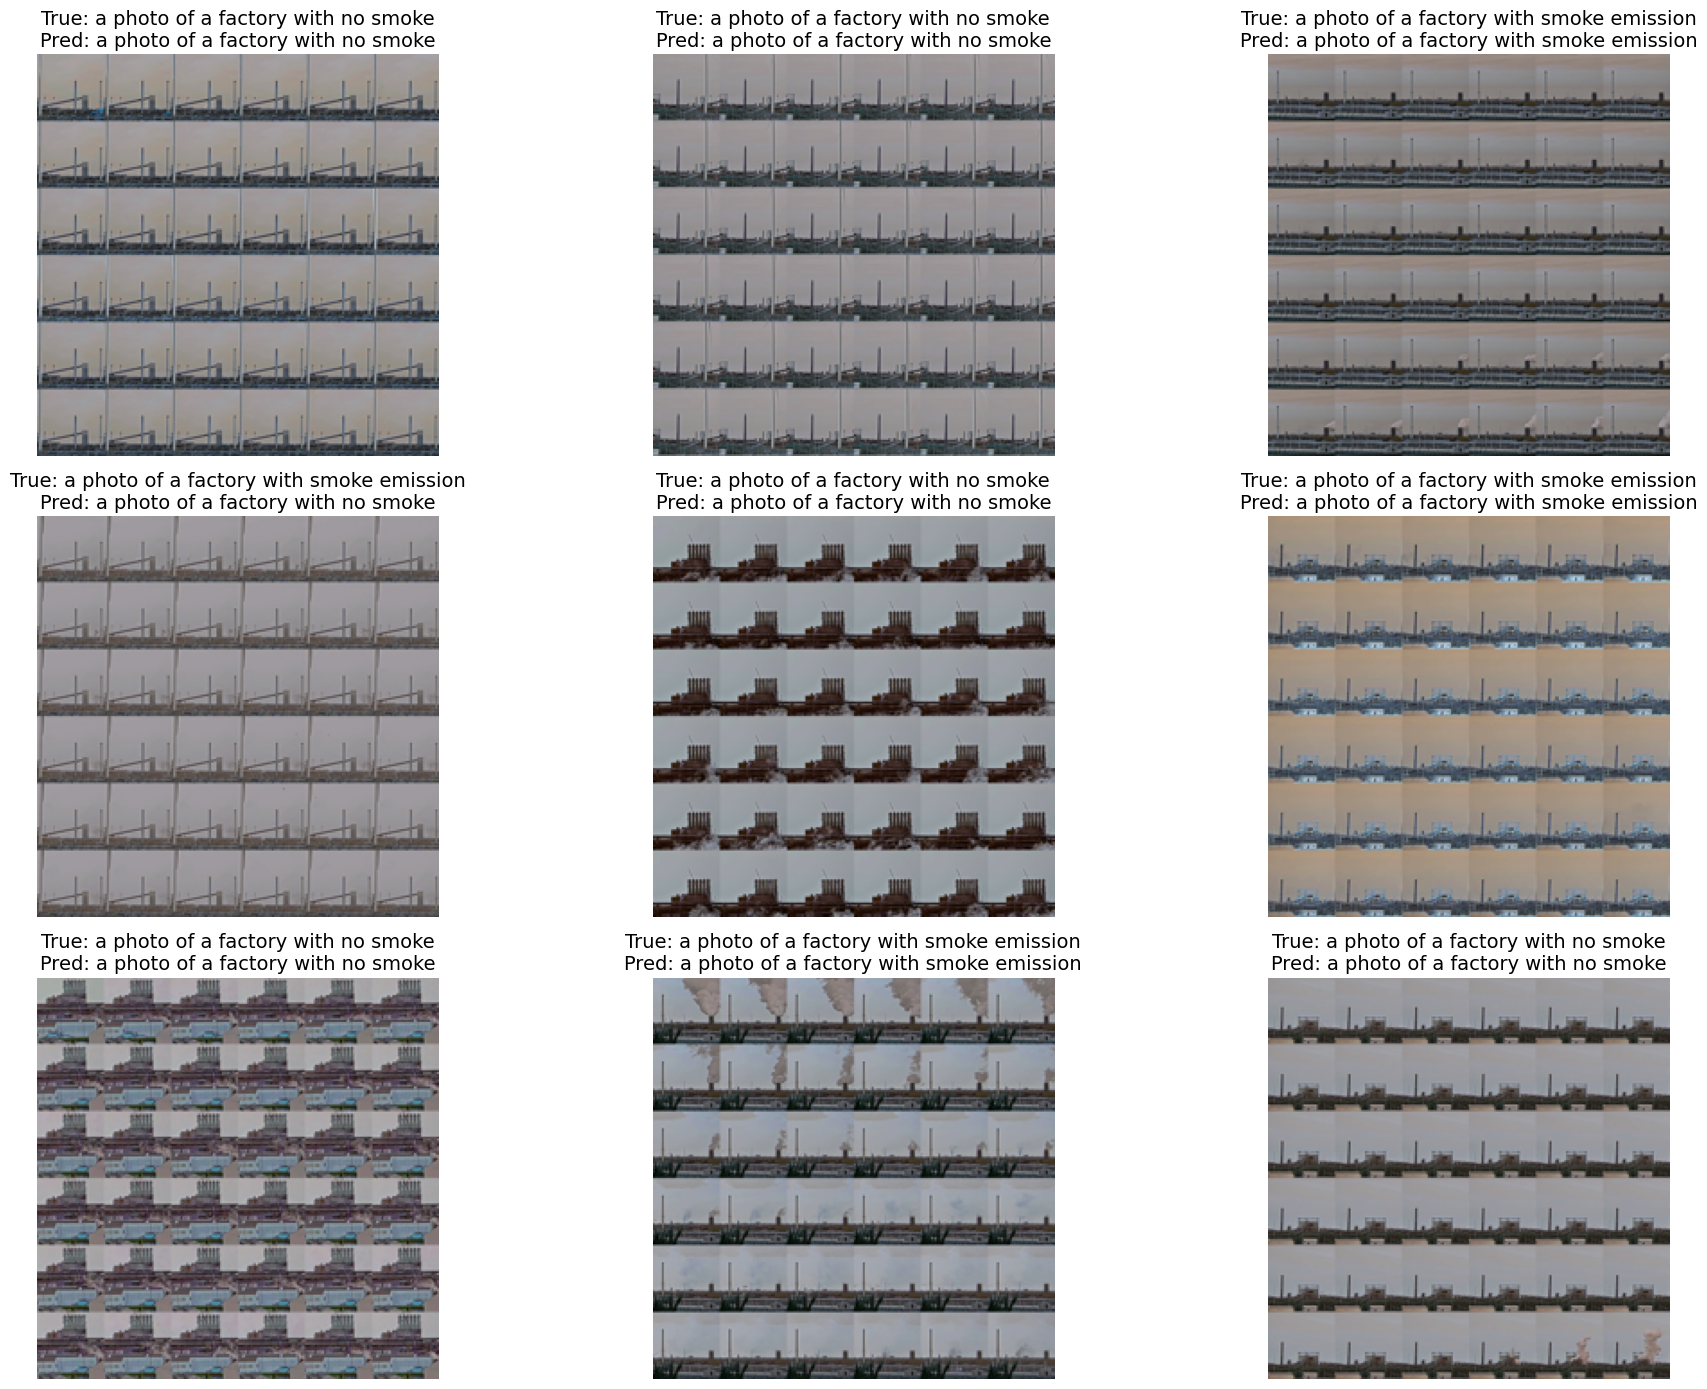

In [7]:
import os
import random
import clip
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import json
import pandas as pd
import cv2

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model - ViT B32
model, preprocess = clip.load('ViT-B/16', device, jit=False)

# Load the dataset
class ImageTitleDataset(Dataset):
    def __init__(self, list_video_path, list_labels, class_names, transform_image):
        super().__init__()
        self.video_path = list_video_path
        self.labels = list_labels
        self.class_names = class_names
        self.transform_image = transform_image

    @staticmethod
    def preprocess_video_to_image_grid_version(video_path, num_rows=6, num_cols=6):
        video = cv2.VideoCapture(video_path)
        frames = []
        if not video.isOpened():
            print("Error: Could not open video file")
        else:
            while True:
                is_read, frame = video.read()
                if not is_read:
                    break
                frames.append(frame)
            video.release()
        
        if len(frames) != 36:
            print(f"Num of frames for video on {video_path} is {len(frames)}")
        
        rows_list = []
        for i in range(num_rows):
            row = np.concatenate(frames[i * num_cols: (i + 1) * num_cols], axis=1)
            rows_list.append(row)
        
        concatenated_frames = np.concatenate(rows_list, axis=0)
        return concatenated_frames

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        video_path = self.video_path[idx]
        image = self.preprocess_video_to_image_grid_version(video_path)
        image = Image.fromarray(image)
        image = self.transform_image(image)
        true_label = self.labels[idx]
        label = self.class_names[true_label]
        label = clip.tokenize(label, context_length=77, truncate=True)
        return image, label, true_label

# Define the transformation pipeline
input_resolution = (224, 224)
transform = transforms.Compose([
    transforms.Resize(input_resolution, interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711])
])

# Load test data
with open('../data/datasets/experimental_ijmond_dataset.json', 'r') as f:
    test_data = json.load(f)
test_data = pd.DataFrame(test_data)
list_video_path = [os.path.join("../data/ijmond_videos/", f"{fn}.mp4") for fn in test_data['file_name']]
list_labels = [int(label) for label in test_data['label']]
class_names = ["a photo of a factory with no smoke", "a photo of a factory with smoke emission"]

# Create dataset for testing
dataset = ImageTitleDataset(list_video_path, list_labels, class_names, transform)

def visualize_random_images(dataset, num_images=9):
    # Select random indices
    random_indices = random.sample(range(len(dataset)), num_images)
    
    # Prepare plot
    fig, axes = plt.subplots(3, 3, figsize=(20, 14))
    axes = axes.flatten()
    
    # Prepare CLIP model and text inputs
    model.eval()
    text_inputs = clip.tokenize(class_names).to(device)
    
    with torch.no_grad():
        for i, idx in enumerate(random_indices):
            # Get image, label, and true label
            image, label, true_label = dataset[idx]
            image = image.unsqueeze(0).to(device)
            texts = label.to(device)
            texts = texts.squeeze(dim=1)
            text_inputs.squeeze(dim=1)

            # Calculate features
            image_features = model.encode_image(image)
            text_features = model.encode_text(text_inputs)

            # Calculate similarity
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

            # Predicted label
            predicted_label = similarity.argmax(dim=1).item()

            # Display image and similarity scores
            image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
            image_np = (image_np * np.array([0.26862954, 0.26130258, 0.27577711]) + np.array([0.48145466, 0.4578275, 0.40821073])) * 255
            image_np = image_np.astype(np.uint8)

            axes[i].imshow(image_np)
            axes[i].axis('off')
            axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[predicted_label]}", fontsize=14)

    plt.tight_layout()
    plt.show()

# Visualize random 9 images
visualize_random_images(dataset)
